## Part 1 - Analysis for all the projects in TCGA

Definitions: 
Alive - at least 3 years cancer recurrence. 
Dead - anyone who didn't survive the cancer and declared "Dead" in the clinical files.

Objectives: The main purpose of the first part is to check which project have 0.2<Alive/(Dead+Alive)<0.8. The reason for this is to create 2 groups big enough so the models that we will create will be much more reliable.

Disclaimer: all analysis is based on TCGA an CPTAC3 RNAseq FPKM-UQ datafiles which are not included in the repository due to limited access restriction. In order to download those files one should apply to the Data Access Committee using dbGaP website:
https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/study.cgi?study_id=phs000178.v11.p8
https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/study.cgi?study_id=phs001287.v4.p3


In [1]:
#getting the list of the files in the folder
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

'''
    For the given path, get the List of all files in the directory tree 
'''

import pandas as pd
ENSG_key = pd.read_csv("biomart_database.txt")
ENSG_key = ENSG_key.drop(["Transcript stable ID","HGNC symbol","HGNC ID","Protein stable ID","RefSeq match transcript","Transcript name"],axis=1)
ENSG_key = ENSG_key.drop_duplicates()
ENSG_key = ENSG_key.set_index("Gene stable ID")

def ENSG_to_gene(list_of_genes):
    ENSG_key_dic = ENSG_key.to_dict()["Gene name"]
    list_HUGO = []
    for ENSG in list_of_genes:
        if "." in ENSG:
            gene = ENSG.split(".")[0]
        else:
            gene = ENSG
        try:
            print(ENSG_key_dic[gene])
            list_HUGO.append(ENSG_key_dic[gene])
        except KeyError:
            list_HUGO.append(gene)
            print(gene)
    return(list_HUGO)
    
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

def get_clinical_data(clinical_file):
    #clinical
    clinical_prp = pd.read_csv(clinical_file,delimiter="\t",header=None)
    clinical_prp = clinical_prp.set_index(0)
    clinical_prp = clinical_prp.transpose()
    clinical_prp["patient.bcr_patient_barcode"] = clinical_prp["patient.bcr_patient_barcode"].str.upper()
    clinical_prp = clinical_prp.set_index("patient.bcr_patient_barcode")
    clinical = clinical_prp
    return(clinical)

def get_dead_alive_stats_from_clinical(clinical_db):
    try: 
        c = clinical_db[["patient.days_to_death","patient.days_to_last_followup","patient.vital_status","patient.person_neoplasm_cancer_status"]]
    except KeyError: return(0,100)
    c["patient.days_to_death"] = pd.to_numeric(c["patient.days_to_death"])
    c["patient.days_to_last_followup"] = pd.to_numeric(c["patient.days_to_last_followup"])
    c = c.replace(np.NaN,-1)
    #dead_ls = list(c[(c["patient.days_to_last_followup"]==-1.0) & (c["patient.days_to_death"]<survive_till)].index)
    #alive_ls = list(c[(c["patient.days_to_last_followup"]>survive_till) & (c["patient.days_to_death"]==-1)].index)
    dead_ls = list(c[(c["patient.vital_status"]=="dead")].index)
    alive_ls = list(c[(c["patient.days_to_last_followup"]>survive_till) & \
                      (c["patient.person_neoplasm_cancer_status"]=="tumor free")\
                      & (c["patient.vital_status"]=="alive")].index)
    #print("dead:",len(dead_ls),"alive:",len(alive_ls))
    return(dead_ls,alive_ls)

def get_X_Y(data_frame,full_alive_ls,full_dead_ls):
    Y =[]
    #prepere Y
    for sample in list(data_frame.index):
        if (sample in full_alive_ls) and (sample in full_dead_ls): print("ERR:",sample)
        if sample in full_alive_ls: Y.append(1)
        if sample in full_dead_ls: Y.append(0)
    X = data_frame.values.tolist()
    return(X,Y)

def get_AUC(y,pred):
    import numpy as np
    from sklearn import metrics
    fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=None)
    return(metrics.auc(fpr, tpr))

#create module and calc on data
def RF_moudule(rna,dead_ls,alive_ls,alive_ls_test = [] ,dead_ls_test = [] ):
    #mixing the lists           
    alive_dead_ls = dead_ls+alive_ls
    import random
    random.seed(1)
    random.shuffle(alive_dead_ls)
    list_len = len(alive_dead_ls)

    # splitting the list berween train ,val and test
    alive_dead_ls_train = alive_dead_ls[:int(list_len*0.7)]
    alive_dead_ls_val = alive_dead_ls[int(list_len*0.7):]

    #train the model
    rna = rna.fillna(0)
    X,Y = get_X_Y(rna.loc[alive_dead_ls_train,:].fillna(0),alive_ls,dead_ls)
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import GridSearchCV
    clf = RandomForestClassifier(max_depth=2, random_state=0, n_estimators=400)
    parameters = { 'max_features':np.arange(5,10),'n_estimators':[100,500,1000],'min_samples_leaf': [10,50,100],"max_depth":[2,5,10]}
    #random_grid = GridSearchCV(rf, parameters, cv = 5)
    clf.fit(X, Y)

    #val the model
    X,Y = get_X_Y(rna.loc[alive_dead_ls_val,:].fillna(0),alive_ls,dead_ls)
    
    pred = clf.predict_proba(X)
    #print("pred",pred,Y)
    y = np.array(Y)
    pred = pred[:,1]
    auc_val = get_AUC(y,pred)
    print("features:",len(rna.columns),"valAUC-ROC",auc_val)
    
    #test the model on the trainning data
    X,Y = get_X_Y(rna.loc[alive_dead_ls_train,:].fillna(0),alive_ls,dead_ls)
    pred = clf.predict_proba(X)
    y = np.array(Y)
    pred = pred[:,1]
    auc_train_data = get_AUC(y,pred)
    print("features:",len(rna.columns),"trainning_AUC-ROC",auc_train_data)
    
    #test on C3
    if (alive_ls_test != [] and dead_ls_test != []):
        #alive_C3 = ["C3L-00008","C3L-00032","C3L-00098","C3L-00136","C3L-00137","C3L-00143","C3L-00145","C3L-00156","C3L-00157","C3L-00362","C3L-00413","C3L-00449","C3L-00905","C3L-00921","C3L-00942","C3L-00946","C3L-00949","C3L-00961","C3L-01312","C3N-00323","C3N-00880"]
        #dead_C3 = ["C3L-00771","C3L-01307","C3L-00139","C3N-00200","C3N-01349","C3N-01520","C3N-01003"]
        X,Y = get_X_Y(rna.loc[alive_C3+dead_C3,:].fillna(0),alive_C3,dead_ls_test)
        pred = clf.predict_proba(X)
        #print("pred",pred,Y)
        y = np.array(Y)
        pred = pred[:,1]
        auc_c3 = get_AUC(y,pred)
        #print("predictions",clf.predict(X),Y)
        print("features:",len(rna.columns),"test_C3_AUC-ROC",auc_c3)
    else:
        auc_c3=0
    #sorting the genes by importance
    genes_importance = pd.DataFrame(clf.feature_importances_, index = rna.columns)
    genes_importance_sorted = genes_importance.sort_values(by =[0],ascending=False)
    return (clf,auc_val,auc_train_data,auc_c3,list(genes_importance_sorted.index))

def get_FPKM_values(metadata,parent_dir,dead_ls,alive_ls):
    list_of_FPKM_files = []
    c=0
    count_avilable_dead = 0
    count_avilable_alive = 0
    
    for index,line in metadata.iterrows():
        if index not in dead_ls+alive_ls: continue
        c+=1
        #print(index)
        #first DF, creating the base for joinning more DF
        if c==1:
            all_FPKM = pd.read_csv(parent_dir+"\\"+line["file_id"]+"\\"+line["file_name"], compression='gzip',delimiter="\t",index_col=0,names=[index])
            continue
        try:
            all_FPKM = all_FPKM.join(pd.read_csv(parent_dir+"\\"+line["file_id"]+"\\"+line["file_name"], compression='gzip',delimiter="\t",index_col=0,names=[index]))
            if index in dead_ls: count_avilable_dead+=1
            if index in alive_ls: count_avilable_alive+=1
        except ValueError: continue
    print("avil alive",count_avilable_alive,"avil dead",count_avilable_dead)
    return all_FPKM



'def get_FPKM_values(metadata,parent_dir,dead_ls,alive_ls):\n    list_of_FPKM_files = []\n    c=0\n    for index,line in metadata.iterrows():\n        if index not in dead_ls+alive_ls: continue\n        c+=1\n        #print(index)\n        #first DF, creating the base for joinning more DF\n        if c==1:\n            all_FPKM = pd.read_csv(parent_dir+"\\"+line["file_id"]+"\\"+line["file_name"], compression=\'gzip\',delimiter="\t",index_col=0,names=[index])\n            continue\n        try:\n            all_FPKM = all_FPKM.join(pd.read_csv(parent_dir+"\\"+line["file_id"]+"\\"+line["file_name"], compression=\'gzip\',delimiter="\t",index_col=0,names=[index]))\n        except ValueError: continue\n    return all_FPKM'

In [2]:
from IPython.display import clear_output
def RF_moudule_GridSearch(rna,dead_ls,alive_ls):
    #mixing the lists           
    alive_dead_ls = dead_ls+alive_ls
    import random
    random.seed(1)
    random.shuffle(alive_dead_ls)
    list_len = len(alive_dead_ls)

    # splitting the list berween train ,val and test
    #alive_dead_ls_train = alive_dead_ls[:int(list_len*0.7)]
    #alive_dead_ls_val = alive_dead_ls[int(list_len*0.7):]

    #train the model
    rna = rna.fillna(0)
    X,Y = get_X_Y(rna.loc[alive_dead_ls,:].fillna(0),alive_ls,dead_ls)
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import GridSearchCV
    rf = RandomForestClassifier()
    #parameters = { 'max_features':np.arange(1,5,10),'n_estimators':[100,300,500,1000],'min_samples_leaf': [10,50,100],"max_depth":[2,5,10],random_state=[0]}
    parameters = {'bootstrap': [True, False], 'max_depth': [10, 50, 100, None], 'max_features': ['auto', 'sqrt'], 'min_samples_leaf': [1, 2, 4],\
    'min_samples_split': [2, 5, 10], 'n_estimators': [200, 600, 1000],"random_state":[0]}
    
    #parameters = { 'max_depth':[2],'n_estimators':[400]} #this is just for testing
    #max_depth=2, random_state=0, n_estimators=400
    
    random_grid = GridSearchCV(rf, parameters, cv = 3, refit=True, verbose=2,n_jobs=1)
    clear_output(wait=True)
    random_grid.fit(X, Y)
    best_clf = random_grid.best_estimator_
    return (best_clf)

In [3]:
#dirName = "TCGA_uterus_CESC_all_patiets.tar/";
# Get the list of all files in directory tree at given path
#listOfFiles = getListOfFiles(dirName)


payload_start = """{
    "filters":{
        "op":"in",
        "content":{
            "field":"files.file_id",
            "value":["""
payload_end = """            ]
        }
    },
    "format":"TSV",
    "fields":"file_id,file_name,cases.submitter_id,cases.case_id,data_category,data_type,cases.samples.tumor_descriptor,cases.samples.tissue_type,cases.samples.sample_type,cases.samples.submitter_id,cases.samples.sample_id,cases.samples.portions.analytes.aliquots.aliquot_id,cases.samples.portions.analytes.aliquots.submitter_id",
    "size":"10000"
}"""
#geti all the files list from the lib
list_of_dir = ["all_TCGA_projects"]
listOfFiles = []
for loc in list_of_dir:
    listOfFiles+=getListOfFiles(loc)
    
#creating a list of the files for the payload
string_of_files_labels = ""
for file_name in listOfFiles:
    if file_name[-3:]!=".gz": continue
    file_label = file_name.split("\\")[1]
    string_of_files_labels+="\""+file_label+"\",\n"
    
string_of_files_labels=string_of_files_labels[:-2]+"\n"
#print(string_of_files_labels)
#creating the Payload_txt file (working accoring the instruction of https://docs.gdc.cancer.gov/API/Users_Guide/Search_and_Retrieval/#example-http-post-request)
file = open("Payload.txt","w")
file.write(payload_start+string_of_files_labels+payload_end)
file.close()

print("Now, Please run from this path in cygwin the following command: curl --request POST --header \"Content-Type: application/json\" --data @Payload.txt 'https://api.gdc.cancer.gov/files' > File_metadata.txt")


Please run from this path in cygwin the following command: curl --request POST --header "Content-Type: application/json" --data @Payload.txt 'https://api.gdc.cancer.gov/files' > File_metadata.txt


In [4]:
#import file-sample keys, and cleaning all the normal tissue RNA-seq samples
import pandas as pd
metadata = pd.read_csv("File_metadata.txt",delimiter="\t")
metadata.head()
metadata = metadata[["cases.0.submitter_id","file_id","file_name","cases.0.samples.0.sample_type"]]
metadata = metadata.set_index("cases.0.submitter_id")
metadata = metadata[metadata["cases.0.samples.0.sample_type"]!="Solid Tissue Normal"]
metadata.groupby(["cases.0.samples.0.sample_type"]).count()

,file_id,file_name
cases.0.samples.0.sample_type,,
Additional - New Primary,2,2
Additional Metastatic,1,1
Metastatic,380,380
Primary Blood Derived Cancer - Peripheral Blood,151,151
Primary Tumor,6826,6826
Recurrent Tumor,29,29


In [104]:
metadata1 = pd.read_csv("File_metadata.txt",delimiter="\t")

In [8]:
#calculating which project have the 0.2<alive/(alive+dead)<0.8 ratio using the clinical data files downloaded from firehose
survive_till = 1095 # 1095 days  = 3 years of survival without a tumer
dead_alive_stats = []
projects_for_analysis= {}
projects_not_for_analysis = []
import glob, re
list_of_clinical_files = glob.glob("clinical/*")
for clinic_file in list_of_clinical_files: 
    project_name = re.findall("[_][\D]{2,9}[.]",clinic_file)
    TCGA_project_name = project_name[0].replace("_","").replace(".","")
    clinical_location = clinic_file+"\\"+TCGA_project_name+".clin.merged.txt"
    clinical_df = get_clinical_data(clinical_location)
    #print("----------------")
    #print("TCGA_project_name:",TCGA_project_name)
    dead_ls,alive_ls=get_dead_alive_stats_from_clinical(clinical_df)
    try:
        alive_per = len(alive_ls)/(len(dead_ls)+len(alive_ls))
        print(TCGA_project_name,"alive:",len(alive_ls)," | dead",len(dead_ls), " | alive %:",alive_per)
    except TypeError:
        print(alive_ls,dead_ls)
        

    if (alive_per>0.2 and alive_per<0.8): 
        projects_for_analysis[TCGA_project_name]={"alive_ls":alive_ls,"dead_ls":dead_ls}
        #if the project is for analysis, first we will calculte the cls, for the whole 65K~ features
        
    else: 
        projects_not_for_analysis.append(TCGA_project_name)
#print(projects_for_analysis)

BLCA alive: 49  | dead 109  | alive %: 0.310126582278481
BRCA alive: 193  | dead 104  | alive %: 0.6498316498316499
CESC alive: 53  | dead 60  | alive %: 0.4690265486725664
COAD alive: 20  | dead 57  | alive %: 0.2597402597402597
COADREAD alive: 23  | dead 66  | alive %: 0.25842696629213485
ESCA alive: 7  | dead 57  | alive %: 0.109375
GBM alive: 3  | dead 446  | alive %: 0.0066815144766146995
GBMLGG alive: 31  | dead 538  | alive %: 0.054481546572934976
HNSC alive: 50  | dead 170  | alive %: 0.22727272727272727
KICH alive: 48  | dead 10  | alive %: 0.8275862068965517
KIPAN alive: 246  | dead 204  | alive %: 0.5466666666666666
KIRC alive: 159  | dead 162  | alive %: 0.4953271028037383
KIRP alive: 39  | dead 32  | alive %: 0.5492957746478874
100 0
LGG alive: 28  | dead 92  | alive %: 0.23333333333333334
LIHC alive: 32  | dead 91  | alive %: 0.2601626016260163
LUAD alive: 39  | dead 127  | alive %: 0.23493975903614459
LUSC alive: 49  | dead 161  | alive %: 0.23333333333333334
OV alive: 4

IndexError: list index out of range

In [104]:
alive_ls = projects_for_analysis["KIRP"]["alive_ls"]
dead_ls = projects_for_analysis["KIRP"]["dead_ls"]
try:
    if len(alive_ls)==0 or len(dead_ls)==0:
        print("ERROR:",alive_ls,dead_ls)
        
except TypeError:
    print("ERROR:",alive_ls,dead_ls)
    

FPKM_project_df = get_FPKM_values(metadata,"all_TCGA_projects\\",dead_ls,alive_ls)
FPKM_project_df_t = FPKM_project_df.transpose()

avil alive 37 avil dead 32


##### creating models for the project with good alive_%

In [3]:
#get the ENSG key
import pandas as pd
ENSG_key = pd.read_csv("biomart_database.txt")
ENSG_key = ENSG_key.drop(["Transcript stable ID","HGNC symbol","HGNC ID","Protein stable ID","RefSeq match transcript","Transcript name"],axis=1)
ENSG_key = ENSG_key.drop_duplicates()
ENSG_key = ENSG_key.set_index("Gene stable ID")

projects_auc_0_7 = []
projects_res ={}

#start the analysis for projects

for TCGA_project in list(projects_for_analysis.keys()):
#for TCGA_project in ["KIRC"]:
    #getting the samples and prepering the DataFrame
    print("---------------------------------------------------------")
    print(TCGA_project)
    #if TCGA_project=="BLCA": continue
    #if TCGA_project!="BRCA": continue
    alive_ls = projects_for_analysis[TCGA_project]["alive_ls"]
    dead_ls = projects_for_analysis[TCGA_project]["dead_ls"]
    try:
        if len(alive_ls)==0 or len(dead_ls)==0:
            print("ERROR:",alive_ls,dead_ls)
            continue
    except TypeError:
        print("ERROR:",alive_ls,dead_ls)
        continue
     
    FPKM_project_df = get_FPKM_values(metadata,"all_TCGA_projects\\",dead_ls,alive_ls)
    FPKM_project_df_t = FPKM_project_df.transpose()
    #testing the best classifier for the 65k features

    clf_best_clf_65k = RF_moudule_GridSearch(FPKM_project_df_t,dead_ls,alive_ls)

    #after we got the best classifier we'll calculate the AUC with it
    print(clf_best_clf_65k)
    
    X,Y = get_X_Y(FPKM_project_df_t.loc[alive_ls+dead_ls,:].fillna(0),alive_ls,dead_ls)
    pred = clf_best_clf_65k.predict_proba(X)
    #print("pred",pred,Y)
    y = np.array(Y)
    pred = pred[:,1]
    auc_all = get_AUC(y,pred)
    print("allAUC-ROC, 65k features: ",auc_all)
    
    #getting the 100-1K features form clf_best_clf_65k
    genes_importance = pd.DataFrame(clf_best_clf_65k.feature_importances_, index = FPKM_project_df_t.columns)
    genes_importance_fltr = genes_importance[genes_importance[0]>0]
    
    # splitting the data to train and val.
    alive_dead_ls = dead_ls+alive_ls
    import random
    random.seed(1)
    random.shuffle(alive_dead_ls)
    list_len = len(alive_dead_ls)
    alive_dead_ls_train = alive_dead_ls[:int(list_len*0.7)]
    alive_dead_ls_val = alive_dead_ls[int(list_len*0.7):]
    
    #finding the best model using the train data for 1k features
    FPKM_project_df_t_train = FPKM_project_df_t[list(genes_importance_fltr.index)].loc[alive_dead_ls_train]
    clf_best_clf_1k = RF_moudule_GridSearch(FPKM_project_df_t_train,dead_ls,alive_ls)
    
    print("clf_best_clf_1k: ",clf_best_clf_1k)
    #getting the auc for the validation data
    FPKM_project_df_t_val = FPKM_project_df_t[list(genes_importance_fltr.index)].loc[alive_dead_ls_val]
    X,Y = get_X_Y(FPKM_project_df_t_val.fillna(0),alive_ls,dead_ls)
    pred = clf_best_clf_1k.predict_proba(X)
    #print("pred",pred,Y)
    y = np.array(Y)
    pred = pred[:,1]
    auc_all = get_AUC(y,pred)
    print("valAUC-ROC, 1k features",auc_all)
    print(FPKM_project_df_t_train.shape)
    project_models_and_scores={}
    rna_top_fet = FPKM_project_df_t[list(FPKM_project_df_t_train.columns)]

    #checing the model on CPTAC-3 dataset
    alive_C3 = ["C3L-00008","C3L-00032","C3L-00098","C3L-00136","C3L-00137","C3L-00143","C3L-00145","C3L-00156","C3L-00157","C3L-00362","C3L-00413","C3L-00449","C3L-00905","C3L-00921","C3L-00942","C3L-00946","C3L-00949","C3L-00961","C3L-01312","C3N-00323","C3N-00880"]
    dead_C3 = ["C3L-00771","C3L-01307","C3L-00139","C3N-00200","C3N-01349","C3N-01520","C3N-01003"]
    FPKM_project_df_CPTAC = get_FPKM_values(metadata,"all_TCGA_projects\\",dead_C3,alive_C3)
    #genes = projects_res2[model][max_num]['genes']
    FPKM_project_df_CPTAC_uter_t = FPKM_project_df_CPTAC.transpose()
    
    alive_C3 = ["C3L-00010","C3L-00026","C3L-00097","C3L-00359","C3L-00360","C3L-00418","C3L-00447","C3N-00312","C3N-00313"]
    dead_C3 = ["C3L-00011","C3L-00079","C3L-00096","C3L-00369","C3L-01302","C3N-00314","C3N-00491","C3N-00831","C3N-01200","C3L-00088","C3L-01287","C3N-01220"]
    FPKM_project_df_CPTAC = get_FPKM_values(metadata,"all_TCGA_projects\\",dead_C3,alive_C3)
    #genes = projects_res2[model][max_num]['genes']
    FPKM_project_df_CPTAC_renal_t = FPKM_project_df_CPTAC.transpose()
    #sorting the features by importance and running the model using reverse feature selection
    for fet_num in range(len(rna_top_fet.columns),0,-1):
        X,Y = get_X_Y(rna_top_fet.loc[alive_dead_ls_train,:].fillna(0),alive_ls,dead_ls)
        from sklearn.ensemble import RandomForestClassifier
        #clf_best_clf_1k = RandomForestClassifier(max_depth=2, random_state=0, n_estimators=400)
        clf_best_clf_1k.fit(X, Y)
        #test the model
        X,Y = get_X_Y(rna_top_fet.loc[alive_dead_ls_val,:].fillna(0),alive_ls,dead_ls)
        pred = clf_best_clf_1k.predict_proba(X)
        y = np.array(Y)
        pred = pred[:,1]
        auc = get_AUC(y,pred)
        #auc_4proj.append(auc)
        top_genes_list = list(rna_top_fet.columns)
        
        alive_C3 = ["C3L-00008","C3L-00032","C3L-00098","C3L-00136","C3L-00137","C3L-00143","C3L-00145","C3L-00156","C3L-00157","C3L-00362","C3L-00413","C3L-00449","C3L-00905","C3L-00921","C3L-00942","C3L-00946","C3L-00949","C3L-00961","C3L-01312","C3N-00323","C3N-00880"]
        dead_C3 = ["C3L-00771","C3L-01307","C3L-00139","C3N-00200","C3N-01349","C3N-01520","C3N-01003"]
        FPKM_project_df_CPTAC_uter_t = FPKM_project_df_CPTAC_uter_t[top_genes_list]
        #X,Y = get_X_Y(FPKM_project_df_t.loc[alive_C3+dead_C3,:].fillna(0),alive_C3,dead_C3)
        X,Y =get_X_Y(FPKM_project_df_CPTAC_uter_t.loc[alive_C3+dead_C3,:].fillna(0),alive_C3,dead_C3)
        pred = clf_best_clf_1k.predict_proba(X)
        #print("pred",pred,Y)
        y = np.array(Y)
        pred = pred[:,1]
        auc_c3_UCEC = get_AUC(y,pred)
        #if len(top_genes_list)%5==0:
        #    print("prject",TCGA_project,"top features",len(top_genes_list),"AUC-ROC",auc,"CPTAC_AUC",auc_c3)
        #project_models_and_scores[fet_num]={"auc_val_score":auc,"clf":clf_best_clf_1k, "genes":top_genes_list,"CPTAC_AUC":auc_c3}

        alive_C3 = ["C3L-00010","C3L-00026","C3L-00097","C3L-00359","C3L-00360","C3L-00418","C3L-00447","C3N-00312","C3N-00313"]
        dead_C3 = ["C3L-00011","C3L-00079","C3L-00096","C3L-00369","C3L-01302","C3N-00314","C3N-00491","C3N-00831","C3N-01200","C3L-00088","C3L-01287","C3N-01220"]
  
        FPKM_project_df_CPTAC_renal_t = FPKM_project_df_CPTAC_renal_t[top_genes_list]
        #X,Y = get_X_Y(FPKM_project_df_t.loc[alive_C3+dead_C3,:].fillna(0),alive_C3,dead_C3)
        X,Y =get_X_Y(FPKM_project_df_CPTAC_renal_t.loc[alive_C3+dead_C3,:].fillna(0),alive_C3,dead_C3)
        pred = clf_best_clf_1k.predict_proba(X)
        #print("pred",pred,Y)
        y = np.array(Y)
        pred = pred[:,1]
        auc_c3_renal = get_AUC(y,pred)
        #if len(top_genes_list)%5==0:
        #    print("prject",TCGA_project,"top features",len(top_genes_list),"AUC-ROC",auc,"CPTAC_AUC",auc_c3)
        #project_models_and_scores[fet_num]={"auc_val_score":auc,"clf":clf_best_clf_1k, "genes":top_genes_list,"CPTAC_AUC":auc_c3}

        if len(top_genes_list)%5==0:
            print("prject",TCGA_project,"top features",len(top_genes_list),"AUC-ROC",auc,"clf_n_fet",clf_best_clf_1k.n_features_,"CPTAC_AUC_renal",auc_c3_renal, "auc_c3_UCEC",auc_c3_UCEC)
        project_models_and_scores[fet_num]={"auc_val_score":auc,"clf":clf_best_clf_1k, "genes":top_genes_list,"CPTAC_AUC_renal":auc_c3_renal, "auc_c3_UCEC":auc_c3_UCEC}
        #print(top_genes_list)
        #print("-------------------------------------------------------------")

        #removing top features and calculating
        genes_importance = pd.DataFrame(clf_best_clf_1k.feature_importances_, index = rna_top_fet.columns )
        genes_importance_sorted = genes_importance.sort_values(by =[0],ascending=False)
        top_genes_list = genes_importance_sorted.index[:fet_num-1]
        rna_top_fet = rna_top_fet[top_genes_list]
    import pickle
    
    #projects_res[TCGA_project] = project_models_and_scores
    filename = 'dogs'
    outfile = open(TCGA_project+".pickle",'wb')
    pickle.dump(project_models_and_scores,outfile)
    outfile.close()



NameError: name 'projects_for_analysis' is not defined

# extracting the data from the pickle files

In [6]:
import glob
list_of_projects_pickle = glob.glob("*.pickle")
list_of_projects_pickle

['bestmodels.pickle',
 'BLCA.pickle',
 'BRCA.pickle',
 'CESC.pickle',
 'COAD.pickle',
 'COADREAD.pickle',
 'HNSC.pickle',
 'KIPAN.pickle',
 'KIRC.pickle',
 'KIRP.pickle',
 'LGG.pickle',
 'LIHC.pickle',
 'LUAD.pickle',
 'LUSC.pickle',
 'model4web.pickle',
 'READ.pickle',
 'SARC.pickle',
 'SKCM.pickle',
 'UCEC.pickle']

## Pick the best models with minimal parameters, and displaying the genes for further analysis in IPA


#########################

Project file: BLCA.pickle

#########################

Project file: BRCA.pickle

#########################

Project file: CESC.pickle
AUC_mean 0.8097222222222221
AUC_CPTAC3_renal 0.6931851851851852
AUC_CPTAC3_uterus 0.6040816326530613
TCGA-CESC
83 0.8194444444444444
300 0.8159722222222222
list of ENSG genes: 
ENSG00000155099.6
ENSG00000258086.1
ENSG00000072682.17
ENSG00000256124.4
ENSG00000162639.14
ENSG00000226499.1
ENSG00000133328.3
ENSG00000214612.3
ENSG00000132819.15
ENSG00000213237.4
ENSG00000236756.4
ENSG00000235033.6
ENSG00000199038.1
ENSG00000124882.3
ENSG00000115226.8
ENSG00000232070.7
ENSG00000186352.7
ENSG00000240771.5
ENSG00000164283.11
ENSG00000164128.5
ENSG00000126903.14
ENSG00000273009.1
ENSG00000124802.10
ENSG00000118113.10
ENSG00000278487.1
ENSG00000273521.1
ENSG00000149257.12
ENSG00000161638.9
ENSG00000176692.5
ENSG00000262380.1
ENSG00000006453.12
ENSG00000196968.9
ENSG00000112715.19
ENSG00000164111.13
ENSG00000215559.7
ENSG00000138792.8
EN

IndexError: list index out of range

<Figure size 432x288 with 0 Axes>

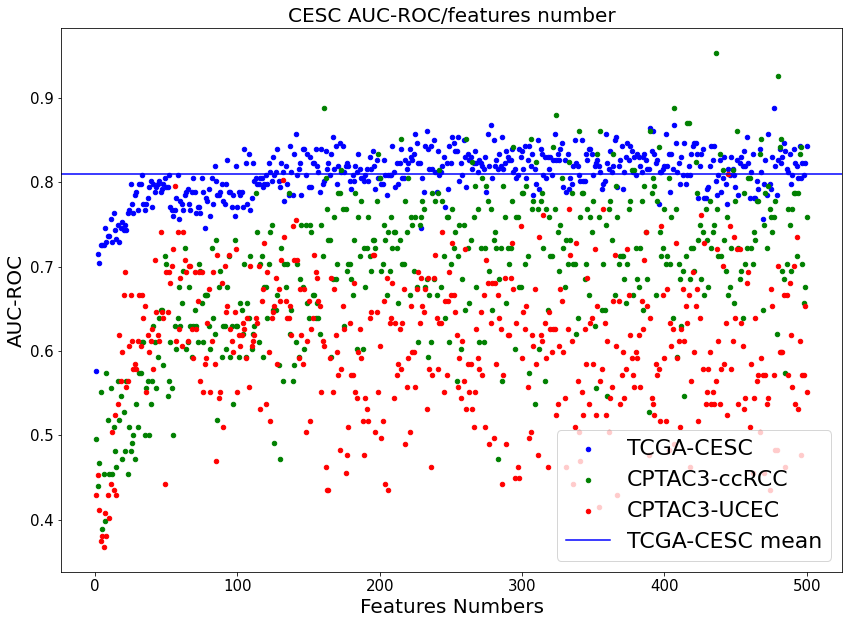

<Figure size 432x288 with 0 Axes>

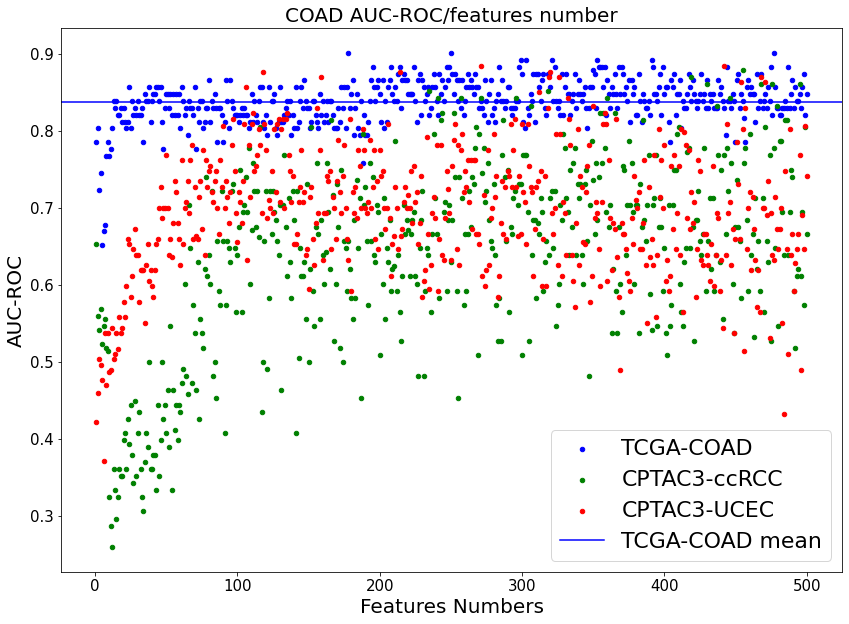

<Figure size 432x288 with 0 Axes>

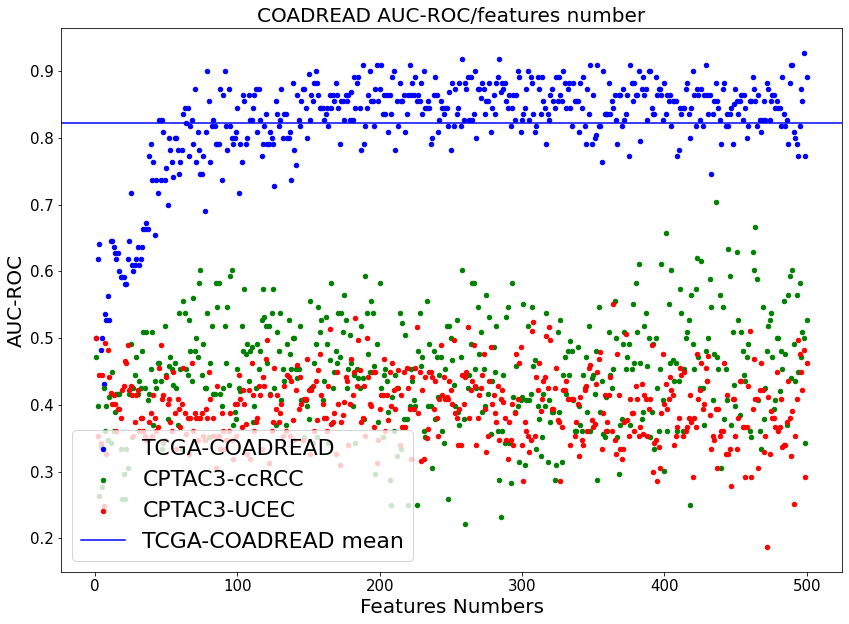

<Figure size 432x288 with 0 Axes>

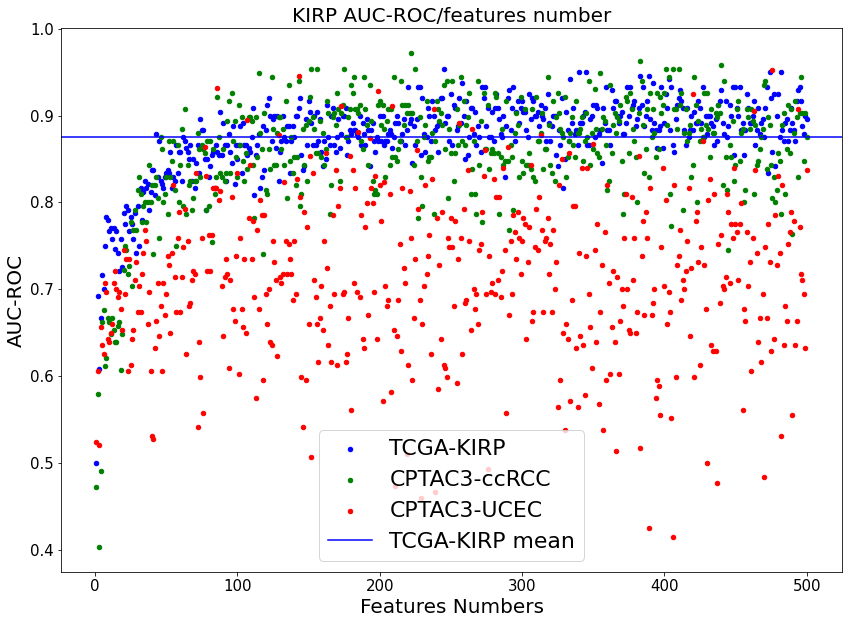

<Figure size 432x288 with 0 Axes>

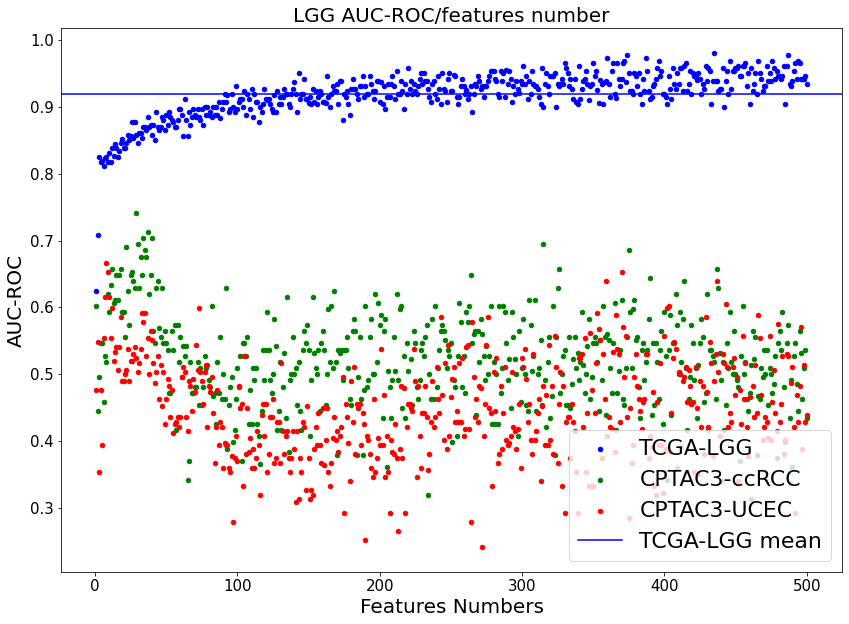

<Figure size 432x288 with 0 Axes>

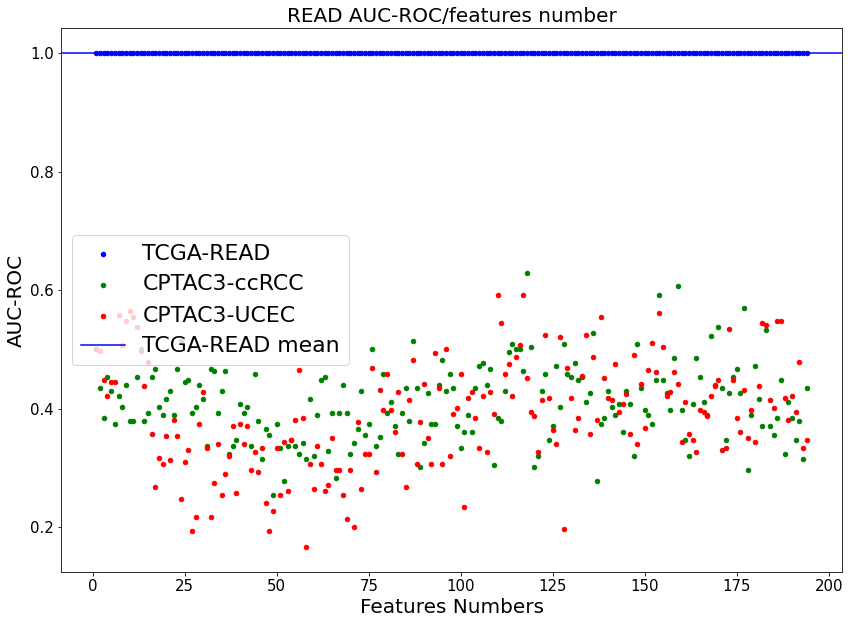

In [10]:

best_model_4web = {}


results = []
import pandas as pd
import glob
list_of_projects_pickle = glob.glob("*.pickle")
for fet_to_calc in [500]:
    for project_file in list_of_projects_pickle:
        if project_file=="model4web.pickle": continue
        if project_file=="bestmodels.pickle": continue
        #if project_file!="CESC.pickle": continue
        project_name = "TCGA-"+project_file.replace(".pickle","")
        print("\n#########################\n")
        print("Project file:",project_file)
        import pickle
        infile = open(project_file,'rb')
        project_dic = pickle.load(infile)
        infile.close()

        import matplotlib.pyplot as plt
        project = project_file
        length = list(project_dic)
        res_df = []

        for fet_num in length:
            res_df.append({"fet_num":fet_num,project_name:project_dic[fet_num]["auc_val_score"],\
                           "CPTAC3-CCRCC":project_dic[fet_num]["CPTAC_AUC_renal"],\
                           "CPTAC3-UCEC":project_dic[fet_num]["auc_c3_UCEC"]})
        res_df = pd.DataFrame.from_dict(res_df).set_index("fet_num")
        avg = res_df.iloc[-fet_to_calc:][project_name].mean()
        if avg<0.8: continue
        print("AUC_mean",avg)
        print("AUC_CPTAC3_renal",res_df.iloc[-fet_to_calc:]["CPTAC3-CCRCC"].mean())
        print("AUC_CPTAC3_uterus",res_df.iloc[-fet_to_calc:]["CPTAC3-UCEC"].mean())

        #ax = res_df.iloc[-fet_to_calc:].plot(figsize=(14,10),ylim=(0,1), title = project[:-7] + " AUC-ROC/features number")
        project_name = res_df.columns[0]
        print(project_name)
        import matplotlib.patches as mpatches
        import matplotlib.pyplot as plt
        plt.figure()
        plt.rcParams.update({'font.size': 60})
        
        res_df["fet_num"] = res_df.index
        ax = res_df.iloc[-500:].plot.scatter(x='fet_num', y=project_name, figsize=(14,10), fontsize=15, color='Blue', label=project_name ,title = project[:-7] + " AUC-ROC/features number");
        ax.xaxis.label.set_size(20)
        ax.yaxis.label.set_size(20)
        ax.title.set_size(20)
        res_df.iloc[-500:].plot.scatter(x='fet_num', y="CPTAC3-CCRCC", color='Green', label="CPTAC3-ccRCC", ax=ax);
        res_df.iloc[-500:].plot.scatter(x='fet_num', y="CPTAC3-UCEC", color='red', label="CPTAC3-UCEC", ax=ax);
        ax.set_xlabel("Features Numbers")
        ax.set_ylabel("AUC-ROC")
        
        
        
        plt.rcParams.update({'font.size': 22})
        import matplotlib.lines as mlines
        blue_line = mlines.Line2D([], [], color='blue',markersize=1, label=project_name + " mean")
        
        #red_patch = mpatches.Patch(color='Blue', label=project_name + "mean", markersize=0.1)
        #plt.legend(handles=[red_patch])
        handles_g, labels = ax.get_legend_handles_labels()
        plt.legend(handles=handles_g+[blue_line])
        plt.axhline(y=avg, color='blue', linestyle='-')
        plt.savefig(project + " AUC-ROC features number.jpeg",bbox_inches='tight')
        
        
        #now we will check what is the lowsst number of features that reach to the average of the AUC
        list_AUC_test = list(res_df.iloc[-500:][project_name])
        list_CPTAC_CCRCC = list(res_df.iloc[-500:]["CPTAC3-CCRCC"])
        list_CPTAC_UCEC = list(res_df.iloc[-500:]["CPTAC3-UCEC"])
        
        list_AUC_test.reverse()
        list_CPTAC_CCRCC.reverse()
        list_CPTAC_UCEC.reverse()
        #print(list_AUC_test)

        #doing t-test
        from scipy.stats import ttest_ind
        AUC_test = list(res_df[project_name].values)
        AUC_CPTAC3_renal = list(res_df["CPTAC3-CCRCC"].values)
        AUC_CPTAC3_uterus = list(res_df["CPTAC3-UCEC"].values)
        #print("T-Test between AUC_test and AUC_CPTAC3_uterus", ttest_ind(AUC_test, AUC_CPTAC3_uterus))
        #print("T-Test between AUC_test and AUC_CPTAC3_renal", ttest_ind(AUC_test, AUC_CPTAC3_renal))
        #print("T-Test between AUC_CPTAC3_uterus and AUC_CPTAC3_renal", ttest_ind(AUC_CPTAC3_uterus, AUC_CPTAC3_renal))

        #try:
        for pos in range(0,fet_to_calc,1):
            #print(pos)
            if list_AUC_test[pos]>=avg:
                print(pos, list_AUC_test[pos])
                print(300, list_AUC_test[300])
                #print("prediction for CPTAC sets - CCRCC:",list_CPTAC_CCRCC[pos],"UCEC:",list_CPTAC_UCEC[pos])
                best_model_4web[project_file]= project_dic[pos]
                break
        """except:
            print("calc for 100 features only")
            for pos in range(0,100,1):
                #print(pos)
                if list_AUC_test[pos]>=avg:
                    #print(pos, list_AUC_test[pos])
                    break"""

        try:
            gene_list = project_dic[pos]["genes"]
        except:
            continue

        print("list of ENSG genes: ")

        #print the results to file for each project:
        f=open(project + "_ENSG__results_fet"+str(fet_to_calc)+".txt","w")
        for gene in gene_list: 
            print(gene)
            f.writelines(gene+"\n")
        f.close()
        print("\nGene Names: ")
        hugo_gene_list = ENSG_to_gene(gene_list)
        #results.append({"Project Name":project_file,"Features Checked":fet_to_calc,"Genes Names":hugo_gene_list, \
        #               "AUC_mean":avg,"CPTAC3-CCRCC":res_df.iloc[-fet_to_calc:]["CPTAC3-CCRCC"].mean(),\
        #               "CPTAC3-UCEC":res_df.iloc[-fet_to_calc:]["CPTAC3-UCEC"].mean(),\
        #              "Number of features for near averaged AUC":pos, "AUC using selected fet":list_AUC_test[pos]})
        
        #printing the list of genes in model with 300 genes
        gene_list_300 = project_dic[300]["genes"]
        f=open(project + "_ENSG__results_fet_all300"+".txt","w")
        print(project_dic[300]["genes"])
        for gene in gene_list_300: 
            #print(gene)
            #f.writelines(gene+"\n")
            continue
        f.close()
        


In [13]:
# saving the best models for deploying in the webapp
outfile = open("bestmodels.pickle",'wb')
pickle.dump(best_model_4web,outfile)
outfile.close()

In [12]:
project_dic[pos].keys()

dict_keys(['auc_val_score', 'clf', 'genes', 'CPTAC_AUC_renal', 'auc_c3_UCEC'])

In [1]:
import pickle
# check the renal result on models4web kirp model

#importing the types of cancer
infile = open("model4web.pickle","rb")
dic = pickle.load(infile)
infile.close()
model = dic["KIRP.pickle"]["clf"]
len(model.feature_importances_)

42

# scatch code


In [9]:
import pickle
# check the renal result on models4web kirp model

#importing the types of cancer
infile = open("model4web.pickle","rb")
dic = pickle.load(infile)
infile.close()
top_genes_list = dic["KIRP.pickle"]["genes"]
model = dic["KIRP.pickle"]["clf"]
len(model.feature_importances_)

42

In [11]:
alive_ls = projects_for_analysis["KIRP"]["alive_ls"]
dead_ls = projects_for_analysis["KIRP"]["dead_ls"]
try:
    if len(alive_ls)==0 or len(dead_ls)==0:
        print("ERROR:",alive_ls,dead_ls)
        
except TypeError:
    print("ERROR:",alive_ls,dead_ls)
    

FPKM_project_df = get_FPKM_values(metadata,"all_TCGA_projects\\",dead_ls,alive_ls)
avl_samples=[]
for sample in alive_ls+dead_ls:
    if sample in FPKM_project_df.columns:
        avl_samples.append(sample)
print(avl_samples)

FPKM_project_df = FPKM_project_df[avl_samples]
FPKM_project_df_t = FPKM_project_df.transpose()
#FPKM_project_df_t = FPKM_project_df_t/FPKM_project_df_t.max().max()
FPKM_project_df_t.columns.str.split(".").to_list()
def Extract(lst): 
    return [item[0] for item in lst] 
a = FPKM_project_df_t.columns.str.split(".").to_list()
FPKM_project_df_t.columns = Extract(a)
FPKM_project_df_t = FPKM_project_df_t[top_genes_list]


avil alive 37 avil dead 32
['TCGA-2Z-A9J9', 'TCGA-AL-3468', 'TCGA-BQ-7046', 'TCGA-DW-7834', 'TCGA-DZ-6134', 'TCGA-HE-A5NF', 'TCGA-UZ-A9PR', 'TCGA-2Z-A9J1', 'TCGA-2Z-A9J2', 'TCGA-2Z-A9J5', 'TCGA-2Z-A9J6', 'TCGA-2Z-A9J8', 'TCGA-2Z-A9JE', 'TCGA-2Z-A9JG', 'TCGA-2Z-A9JI', 'TCGA-5P-A9KH', 'TCGA-AL-3467', 'TCGA-BQ-5875', 'TCGA-BQ-5881', 'TCGA-BQ-7044', 'TCGA-BQ-7050', 'TCGA-BQ-7051', 'TCGA-BQ-7053', 'TCGA-DZ-6132', 'TCGA-DZ-6135', 'TCGA-G7-A8LE', 'TCGA-GL-6846', 'TCGA-HE-A5NJ', 'TCGA-HE-A5NK', 'TCGA-P4-A5E6', 'TCGA-P4-A5E7', 'TCGA-P4-A5EB', 'TCGA-P4-A5ED', 'TCGA-P4-AAVM', 'TCGA-P4-AAVO', 'TCGA-SX-A71S', 'TCGA-SX-A7SS', 'TCGA-UZ-A9PS', 'TCGA-2Z-A9JS', 'TCGA-BQ-7049', 'TCGA-BQ-7058', 'TCGA-IA-A83W', 'TCGA-2Z-A9J3', 'TCGA-2Z-A9J7', 'TCGA-5P-A9JY', 'TCGA-5P-A9K3', 'TCGA-5P-A9K9', 'TCGA-A4-7585', 'TCGA-AL-3466', 'TCGA-B9-4113', 'TCGA-BQ-5877', 'TCGA-BQ-5879', 'TCGA-BQ-5880', 'TCGA-BQ-5882', 'TCGA-BQ-5889', 'TCGA-BQ-5893', 'TCGA-BQ-7045', 'TCGA-DZ-6133', 'TCGA-G7-6789', 'TCGA-G7-6793', 'TCGA-G7-A8L

In [29]:
df = np.log2(FPKM_project_df_t)

<AxesSubplot:>

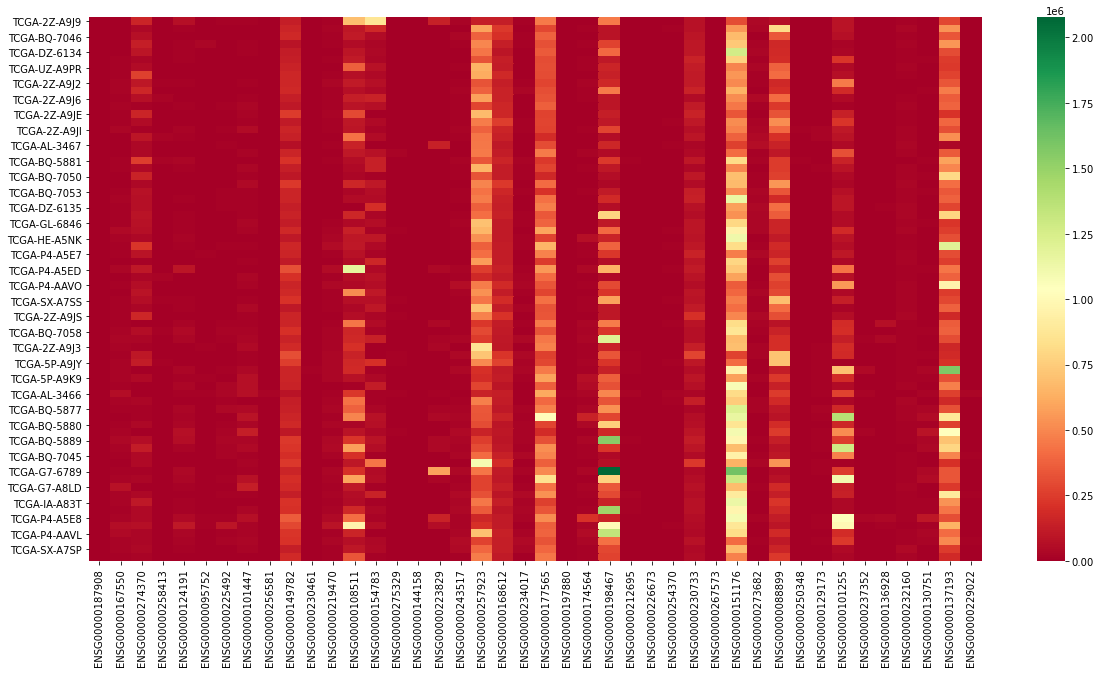

In [40]:

import pandas as pd 
import seaborn as sns 
%matplotlib inline 
fig, ax = plt.subplots(figsize = (20, 10)) 
sns.heatmap(FPKM_project_df_t, cmap ='RdYlGn') 
  

ValueError: The number of FixedLocator locations (70), usually from a call to set_ticks, does not match the number of ticklabels (42).

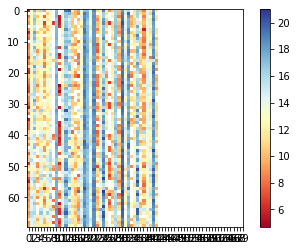

In [30]:
#creating the heatmap
import numpy as np 
import matplotlib.pyplot as plt
#rame as an heatmap 
# with diverging colourmap as RdYlBu 
plt.imshow(df, cmap ="RdYlBu") 
  
# Displaying a color bar to understand 
# which color represents which range of data 
plt.colorbar() 
  
# Assigning labels of x-axis  
# according to dataframe 
plt.xticks(range(len(df)), df.columns) 
  
# Assigning labels of y-axis  
# according to dataframe 
plt.yticks(range(len(df)), df.index) 
  
# Displaying the figure 
plt.show() 

In [15]:
FPKM_project_df_t.head()

,ENSG00000187908,ENSG00000167550,ENSG00000274370,ENSG00000258413,ENSG00000124191,ENSG00000095752,ENSG00000225492,ENSG00000101447,ENSG00000256581,ENSG00000149782,...,ENSG00000088899,ENSG00000250348,ENSG00000129173,ENSG00000101255,ENSG00000237352,ENSG00000136928,ENSG00000232160,ENSG00000130751,ENSG00000137193,ENSG00000229022
TCGA-2Z-A9J9,47.532498,8031.555088,159521.085045,2052.031306,72269.320971,574.660957,11420.531375,14729.024706,0.000000,134197.225395,...,66574.818075,0.000000,2409.897635,84813.907782,1231.877542,319.402243,13782.152568,3864.049655,290278.680423,2699.154895
TCGA-AL-3468,0.000000,5902.490851,36347.171567,5938.000489,9646.717517,0.000000,1618.667772,6665.641183,0.000000,155817.316148,...,817169.497984,0.000000,2912.038059,84442.230428,3055.462760,1056.297264,26019.535108,1720.226323,541375.588480,0.000000
TCGA-BQ-7046,315.390679,7500.283728,65008.058291,1361.576978,5529.954281,190.651363,4330.185289,8024.226993,0.000000,173470.502577,...,344426.228638,673.584378,4305.082765,67472.205715,0.000000,339.090921,12673.139569,8086.143063,333727.685649,2984.934290
TCGA-DW-7834,992.722352,6902.883334,130437.380584,4166.646825,9393.746914,24503.814427,3218.117167,8994.666163,0.000000,87899.124812,...,171987.353483,1177.872950,1720.718744,18281.383950,0.000000,815.314754,19265.018152,3103.891383,549328.766013,2609.824004
TCGA-DZ-6134,479.816185,7292.408978,92378.470518,4438.757902,12447.711296,103.587636,6470.043229,11179.093976,104.211893,124852.733692,...,184933.710611,731.964487,1938.114662,29247.459248,3108.792988,1289.680727,13849.778263,4286.329604,306051.636711,0.000000


# checking if normalization getting better results on validation data

In [144]:
alive_ls = projects_for_analysis["KIRP"]["alive_ls"]
dead_ls = projects_for_analysis["KIRP"]["dead_ls"]
try:
    if len(alive_ls)==0 or len(dead_ls)==0:
        print("ERROR:",alive_ls,dead_ls)
        
except TypeError:
    print("ERROR:",alive_ls,dead_ls)
    

FPKM_project_df = get_FPKM_values(metadata,"all_TCGA_projects\\",dead_ls,alive_ls)

FPKM_project_df_t = FPKM_project_df.transpose()
FPKM_project_df_t = FPKM_project_df_t/FPKM_project_df_t.max().max()

FPKM_project_df_t = FPKM_project_df_t[top_genes_list]
#X,Y = get_X_Y(FPKM_project_df_t.loc[alive_C3+dead_C3,:].fillna(0),alive_C3,dead_C3)
X,Y =get_X_Y(FPKM_project_df_t.fillna(0),alive_ls,dead_ls)
model = dic["KIRP.pickle"]["clf"]
model.fit(X,Y)
print(model.predict_proba(X)[:,1])
print(Y)


#checking C# values after normalization
alive_C3 = ["C3L-00010","C3L-00026","C3L-00097","C3L-00359","C3L-00360","C3L-00418","C3L-00447","C3N-00312","C3N-00313"]
dead_C3 = ["C3L-00011","C3L-00079","C3L-00096","C3L-00369","C3L-01302","C3N-00314","C3N-00491","C3N-00831","C3N-01200","C3L-00088","C3L-01287","C3N-01220"]
FPKM_project_df_CPTAC = get_FPKM_values(metadata,"all_TCGA_projects\\",dead_C3,alive_C3)
#genes = projects_res2[model][max_num]['genes']
FPKM_project_df_CPTAC_renal_t = FPKM_project_df_CPTAC.transpose()
FPKM_project_df_CPTAC_renal_t = FPKM_project_df_CPTAC_renal_t/FPKM_project_df_CPTAC_renal_t.max().max()

FPKM_project_df_CPTAC_renal_t = FPKM_project_df_CPTAC_renal_t[top_genes_list]
X,Y =get_X_Y(FPKM_project_df_CPTAC_renal_t.loc[alive_C3+dead_C3,:].fillna(0),alive_C3,dead_C3)
print(model.predict_proba(X)[:,1])
print(Y)

avil alive 37 avil dead 32
[0.91  0.955 0.96  0.125 0.845 0.82  0.03  0.14  0.815 0.105 0.155 0.06
 0.94  0.09  0.75  0.91  0.855 0.17  0.16  0.15  0.8   0.915 0.87  0.155
 0.155 0.955 0.145 0.935 0.97  0.095 0.15  0.14  0.2   0.91  0.94  0.28
 0.935 0.3   0.95  0.025 0.935 0.07  0.06  0.185 0.935 0.915 0.805 0.06
 0.045 0.11  0.845 0.935 0.025 0.075 0.955 0.87  0.21  0.955 0.28  0.035
 0.9   0.89  0.965 0.23  0.78  0.935 0.94  0.905 0.955 0.905]
[1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
avil alive 8 avil dead 12
[0.35  0.345 0.275 0.385 0.32  0.32  0.235 0.365 0.425 0.315 0.205 0.3
 0.285 0.2   0.18  0.2   0.255 0.28  0.305 0.215 0.195]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [131]:
FPKM_project_df/FPKM_project_df.max()

,TCGA-P4-AAVM,TCGA-2Z-A9J1,TCGA-UZ-A9PS,TCGA-A4-7585,TCGA-HE-A5NK,TCGA-AL-3467,TCGA-P4-A5E8,TCGA-BQ-7058,TCGA-BQ-5881,TCGA-BQ-5877,...,TCGA-2Z-A9J5,TCGA-BQ-7044,TCGA-P4-A5EB,TCGA-SX-A7SP,TCGA-HE-A5NJ,TCGA-HE-A5NF,TCGA-SX-A71S,TCGA-BQ-5875,TCGA-UZ-A9PR,TCGA-2Z-A9J8
ENSG00000242268.2,1.343459e-06,1.402923e-05,1.928548e-06,1.056255e-06,6.771522e-06,5.950988e-05,0.000000,6.823090e-07,0.000000e+00,0.000014,...,0.000004,2.424749e-06,0.000000,1.153707e-05,3.785854e-05,0.000000,0.000180,0.000004,0.000143,0.000000
ENSG00000270112.3,9.320462e-07,1.946600e-07,8.027767e-07,1.465588e-07,3.131901e-07,8.257185e-07,0.000000,4.733627e-08,4.427344e-08,0.000000,...,0.000000,6.728832e-08,0.000000,2.134407e-06,7.504275e-07,0.000000,0.000000,0.000014,0.000000,0.000000
ENSG00000167578.15,4.288355e-05,2.092340e-04,2.208499e-04,9.105206e-05,2.080074e-04,3.584499e-04,0.000178,3.912922e-05,5.506874e-05,0.000805,...,0.000286,4.801335e-05,0.000193,1.501499e-04,1.463019e-04,0.000070,0.000336,0.000053,0.000327,0.000197
ENSG00000273842.1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000078237.5,9.749968e-05,1.687035e-04,2.269282e-04,1.768800e-04,1.547990e-04,3.983402e-04,0.000503,1.618537e-05,2.712871e-05,0.001518,...,0.000158,4.134505e-05,0.000449,1.668702e-04,7.176860e-05,0.000165,0.000533,0.000075,0.000330,0.000372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000105063.17,4.033929e-04,4.935741e-04,1.547110e-03,6.655260e-04,5.776932e-04,3.141784e-03,0.001444,1.228576e-04,9.412221e-05,0.007143,...,0.000380,4.142442e-04,0.001075,4.453607e-04,8.023445e-04,0.000311,0.002201,0.000579,0.001838,0.001793
ENSG00000231119.2,3.163702e-06,3.083484e-05,3.784603e-06,1.243684e-06,7.087202e-06,1.681672e-04,0.000033,1.338970e-06,5.134568e-06,0.000028,...,0.000039,1.142004e-06,0.000014,1.547098e-05,1.485880e-05,0.000012,0.000030,0.000004,0.000065,0.000034
ENSG00000280861.1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
ENSG00000123685.7,1.406349e-06,1.872460e-05,2.826358e-05,2.404899e-05,9.451344e-06,3.270521e-05,0.000035,1.785623e-06,4.258719e-06,0.000134,...,0.000015,1.243745e-05,0.000008,2.138660e-05,1.033231e-04,0.000007,0.000067,0.000006,0.000042,0.000015


In [78]:
alive_C3 = ["C3L-00010","C3L-00026","C3L-00097","C3L-00359","C3L-00360","C3L-00418","C3L-00447","C3N-00312","C3N-00313"]
dead_C3 = ["C3L-00011","C3L-00079","C3L-00096","C3L-00369","C3L-01302","C3N-00314","C3N-00491","C3N-00831","C3N-01200","C3L-00088","C3L-01287","C3N-01220"]
FPKM_project_df_CPTAC = get_FPKM_values(metadata,"all_TCGA_projects\\",dead_C3,alive_C3)
#genes = projects_res2[model][max_num]['genes']
FPKM_project_df_CPTAC_renal_t = FPKM_project_df_CPTAC.transpose()
#def Extract(lst): 
#    return [item[0] for item in lst] 
#a = FPKM_project_df_CPTAC_renal_t.columns.str.split(".").to_list()
#FPKM_project_df_CPTAC_renal_t.columns = Extract(a)


avil alive 8 avil dead 12


In [84]:
alive_C3 = ["C3L-00010","C3L-00026","C3L-00097","C3L-00359","C3L-00360","C3L-00418","C3L-00447","C3N-00312","C3N-00313"]
dead_C3 = ["C3L-00011","C3L-00079","C3L-00096","C3L-00369","C3L-01302","C3N-00314","C3N-00491","C3N-00831","C3N-01200","C3L-00088","C3L-01287","C3N-01220"]

FPKM_project_df_CPTAC_renal_t = FPKM_project_df_CPTAC_renal_t[top_genes_list]
#X,Y = get_X_Y(FPKM_project_df_t.loc[alive_C3+dead_C3,:].fillna(0),alive_C3,dead_C3)
X,Y =get_X_Y(FPKM_project_df_CPTAC_renal_t.loc[alive_C3+dead_C3,:].fillna(0),alive_C3,dead_C3)

In [116]:
model = dic["KIRP.pickle"]["clf"]
model.predict(X)

array([1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1])

In [127]:
np.array(Y)

array([1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1])

In [117]:
pred = model.predict_proba(X)
#print("pred",pred,Y)
y = np.array(Y)
pred = pred[:,1]
auc_c3_renal = get_AUC(y,pred)
auc_c3_renal

0.9810855263157896

In [91]:
pred

array([0.355, 0.325, 0.255, 0.38 , 0.3  , 0.295, 0.195, 0.325, 0.435,
       0.39 , 0.21 , 0.29 , 0.3  , 0.16 , 0.17 , 0.145, 0.215, 0.195,
       0.3  , 0.185, 0.17 ])

In [92]:
Y

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [82]:
for sample in alive_C3:
    l=FPKM_project_df_CPTAC_renal_t[top_genes_list].loc[sample].values
    print(model.predict([l]))

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [43]:
dic["KIRP.pickle"]["genes"]

['ENSG00000187908',
 'ENSG00000167550',
 'ENSG00000274370',
 'ENSG00000258413',
 'ENSG00000124191',
 'ENSG00000095752',
 'ENSG00000225492',
 'ENSG00000101447',
 'ENSG00000256581',
 'ENSG00000149782',
 'ENSG00000230461',
 'ENSG00000219470',
 'ENSG00000108511',
 'ENSG00000154783',
 'ENSG00000275329',
 'ENSG00000144158',
 'ENSG00000223829',
 'ENSG00000243517',
 'ENSG00000257923',
 'ENSG00000168612',
 'ENSG00000234017',
 'ENSG00000177565',
 'ENSG00000197880',
 'ENSG00000174564',
 'ENSG00000198467',
 'ENSG00000212695',
 'ENSG00000226673',
 'ENSG00000254370',
 'ENSG00000230733',
 'ENSG00000267573',
 'ENSG00000151176',
 'ENSG00000273682',
 'ENSG00000088899',
 'ENSG00000250348',
 'ENSG00000129173',
 'ENSG00000101255',
 'ENSG00000237352',
 'ENSG00000136928',
 'ENSG00000232160',
 'ENSG00000130751',
 'ENSG00000137193',
 'ENSG00000229022']

In [9]:
res_pd_sorted = res_pd.sort_values(by=["Project Name","Features Checked"])
#res_pd_sorted_AUC_075 = res_pd_sorted[res_pd_sorted["AUC using selected fet"]>0.75] 

In [10]:
res_pd_sorted

,Project Name,Features Checked,Genes Names,AUC_mean,AUC_CPTAC3_renal,AUC_CPTAC3_uterus,Number of features for near averaged AUC,AUC using selected fet
0,BLCA.pickle,500,"[DNAJC19P9, MMP24, FAM166B, DYM, NT5C3A, GBP2,...",0.758631,0.542528,0.500680,50,0.763105
1,BRCA.pickle,500,"[CLDN14, HACD2, AFG1L, NEFH, ADAMTS8, NACAD, A...",0.705814,0.303444,0.337048,99,0.691077
2,CESC.pickle,500,"[PIP4P2, AC079313.1, P4HA2, LINC01152, HENMT1,...",0.809722,0.693185,0.604082,83,0.819444
3,COAD.pickle,500,"[ZNF266, IZUMO1, ORM2, RPSAP4, DDX50P1, PABPC1...",0.838598,0.637000,0.691973,12,0.839286
4,COADREAD.pickle,500,"[AC091614.1, OR7C1, AC025171.4, RPL37AP8, ZNF2...",0.822482,0.448583,0.397327,44,0.827273
5,HNSC.pickle,500,"[ESRRAP1, TXNRD2, AC136475.10, MOXD1, AL031282...",0.719382,0.504167,0.338687,30,0.721637
6,KIPAN.pickle,500,"[ZIC2, CCNF, EPB41L4A-DT, ELOVL3, SORBS2, AC06...",0.781863,0.813880,0.751469,99,0.776042
7,KIRC.pickle,500,"[SORBS2, ZIC2, CHGA, AC104046.1, CPLANE2, CATS...",0.791925,0.766935,0.651320,96,0.794587
8,KIRP.pickle,500,"[DMBT1, RHEBL1, AC130371.2, AL158801.2, TOX2, ...",0.875458,0.857389,0.712769,42,0.879167
9,LGG.pickle,500,"[AC106037.2, AC112220.2, AC244153.1, SP7, AL64...",0.918581,0.522417,0.448483,90,0.919231


In [14]:
res_pd_sorted.to_csv("results_AUC.csv")

In [20]:
# drewing the graphs of UCEC
import matplotlib.pyplot as plt
for project in projects_res.keys():
    print("\n"+project)
    res_df = []
    length = list(projects_res[project].keys())
    for fet_num in length:
        if project in  ['KIPAN', 'KIRC', 'KIRP']:
            res_df.append({"fet_num":fet_num,"AUC_test":projects_res[project][fet_num]["auc_val_score"],\
                          "AUC_CPTAC_val":projects_res[project][fet_num]["CPTAC_AUC"]})
        else:
            res_df.append({"fet_num":fet_num,"AUC_test":projects_res[project][fet_num]["auc_val_score"]})
            
    res_df = pd.DataFrame.from_dict(res_df).set_index("fet_num")
    avg = res_df.iloc[-100:]["AUC_test"].mean()
    print(avg)
    res_df.iloc[-100:].plot(figsize=(7,5),ylim=(0.4,1), title = project + " AUC/features number")
    plt.axhline(y=avg, color='r', linestyle='-')
    #now we will check what is the lowsst number of features that reach to the average of the AUC
    list_AUC_test = list(res_df.iloc[-100:]["AUC_test"])
    list_AUC_test.reverse()
    #print(list_AUC_test)
    for pos in range(0,100,1):
        #print(pos)
        if list_AUC_test[pos]>=avg:
            print(pos, list_AUC_test[pos])
            break
    try:
        gene_list = projects_res[project][pos]["genes"]
    except KeyError: continue
    ENSG_to_gene(gene_list)


NameError: name 'projects_res' is not defined

In [122]:
ENSG_key

,Gene name
Gene stable ID,
ENSG00000210049,MT-TF
ENSG00000211459,MT-RNR1
ENSG00000210077,MT-TV
ENSG00000210082,MT-RNR2
ENSG00000209082,MT-TL1
...,...
ENSG00000285065,AP002364.2
ENSG00000284997,TUBAP2
ENSG00000284805,RNU6-823P


In [41]:
bst_clf.n_features_
projects_res2["UCEC"][52]['clf'].n_features_

1

## test on CPTAC3

In [78]:
best_auc_genes = []
for tcga_project in projects_res.keys():
    #checking the highest number out of all the possibilities
    print("------------------------------------------------------------------")
    print(tcga_project)
    max_auc = 0
    max_num=0
    for i in range(200,1,-1):
        if max_auc < projects_res[tcga_project][i]["auc_val_score"]:
            max_auc = projects_res[tcga_project][i]["auc_val_score"]
            max_num = i
    pd.DataFrame(projects_res[tcga_project][max_num]["genes"]).to_csv("top_AUC_res/"+tcga_project+".csv", index=False)

------------------------------------------------------------------
BLCA
------------------------------------------------------------------
BRCA
------------------------------------------------------------------
CESC
------------------------------------------------------------------
COAD
------------------------------------------------------------------
COADREAD
------------------------------------------------------------------
HNSC
------------------------------------------------------------------
KIPAN
------------------------------------------------------------------
KIRC
------------------------------------------------------------------
KIRP
------------------------------------------------------------------
LGG
------------------------------------------------------------------
LIHC
------------------------------------------------------------------
LUAD
------------------------------------------------------------------
LUSC
------------------------------------------------------------

In [73]:
pd.DataFrame(best_auc_genes).set_index(0).transpose().to_csv("results_top_AUC_genes.csv")